In [1]:
import os
import cv2
import numpy as np
import mahotas
import pandas as pd
import keras
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.feature import graycomatrix, graycoprops,hog
from skimage import io, color, feature
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import time

In [2]:
names = ['filepath','label','dominant_color_L','dominant_color_A','dominant_color_B','shape_feature','size_feature','texture_feature','pattern']
df = pd.DataFrame([], columns=names)

# Define feature extraction functions
def extract_dominant_color(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    mean_lab = cv2.mean(lab)
    return mean_lab[0], mean_lab[1], mean_lab[2]

def extract_shape_feature(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to create a binary image
    _, binary_image = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # For simplicity, we'll use the number of contours as a shape feature
    shape_feature_value = len(contours)
    
    return shape_feature_value

def extract_size_feature(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to create a binary image
    _, binary_image = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total area of all objects in the image
    total_area = sum([cv2.contourArea(contour) for contour in contours])
    
    # Return the total area as the size feature
    return total_area

def extract_texture_feature(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate GLCM
    glcm = mahotas.features.haralick(gray)

    # You can choose a specific Haralick feature to represent the texture, e.g., correlation
    texture_feature_value = glcm.mean(axis=0)[8]  # 8 corresponds to correlation

    return texture_feature_value

def extract_pattern_feature(image, pattern_template):
    # Convert both the image and the pattern template to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pattern_gray = cv2.cvtColor(pattern_template, cv2.COLOR_BGR2GRAY)
    
    # Perform template matching
    result = cv2.matchTemplate(image_gray, pattern_gray, cv2.TM_CCOEFF_NORMED)
    
    # Set a threshold to identify matches
    threshold = 0.7  # Adjust as needed
    locations = np.where(result >= threshold)
    
    # Count the number of matching patterns
    num_matches = len(locations[0])
    
    return num_matches

def create_dataset():
    names = ['filepath','label','dominant_color_L','dominant_color_A','dominant_color_B','shape_feature','size_feature','texture_feature','pattern']
    df = pd.DataFrame([], columns=names)

    for i, directory in enumerate(os.listdir('flowers_epics')):
        for filename in os.listdir(os.path.join('flowers_epics', directory)):
            # Reading the image
            img = cv2.imread(os.path.join('flowers_epics', directory, filename))

            # Get the full file path
            filepath = os.path.join('flowers_epics', directory, filename)
            
            # Resize image to 100x100
            image = cv2.resize(img, (100, 100))
            
            # Define the coordinates of the region of interest (ROI) for the pattern template
            x, y, width, height = 50, 50, 50, 50  # Example coordinates and dimensions

            # Extract the ROI (pattern template) from the larger image
            pattern_template = image[y:y+height, x:x+width]
            
            # Apply median filter
            image = cv2.medianBlur(image, 3)

            # Apply Gaussian filter
            image = cv2.GaussianBlur(image, (5, 5), 0)
            
            dominant_color_L, dominant_color_A, dominant_color_B = extract_dominant_color(image)
            shape_feature = extract_shape_feature(image)
            size_feature = extract_size_feature(image)
            texture_feature = extract_texture_feature(image)
            pattern = extract_pattern_feature(image, pattern_template)
            
            label=i
            
            # Feature vector
            vector = [
                filepath,
                label,
                dominant_color_L,
                dominant_color_A,
                dominant_color_B,
                shape_feature,
                size_feature,
                texture_feature,
                pattern
            ]
            df_temp = pd.DataFrame([vector], columns=names)
            df = pd.concat([df, df_temp], ignore_index=True)
            print(filename)

            # Append to the images and labels lists
            s = [i, 100, 100, 3]
            images.append(vector)
            labels.append(i)

    return df

In [3]:
images = []
labels = []

In [4]:
dataset = create_dataset()

1015013954_e4fc710ec3_o.jpg
10235201_06bcc37d11_c.jpg
1043937_b9cdc70fd1_h.jpg
1043948_995ecdb0a1_h.jpg
1062615817_27f559c0db_k.jpg
10632906_ab3080d2e8_b.jpg
10646361_d0f1302f05_c.jpg
10746515285_a6391b58e7_o.jpg
1139645956_a7421d3745_o.jpg
11519892835_b973cd5da1_h.jpg
1159496433_a430f3c189_b.jpg
11616948_b4827f7004_h.jpg
1195119061_2e822f348b_o.jpg
1202790616_2470fa0e14_o.jpg
122322606_186ea54a64_o.jpg
123589035_d6b0b239bb_o.jpg
12433437525_932ab3cf61_k.jpg
1262780147_b22f89a050_o.jpg
12831405_ff3fae8661_c.jpg
128553737_709694508a_o.jpg
12889583924_c58f32a51c_o.jpg
13154547503_529b438b58_o.jpg
13290018054_98ce12cc11_b.jpg
1342728163_5dc1dfa25d_o.jpg
1348596520_7235d3a9a6_o.jpg
13489248733_2ae5b4848b_o.jpg
13506957425_e3463eac3a_b.jpg
1355048691_b5a679d860_b.jpg
1368835458_228ffcba5f_k.jpg
13722820875_30ab202067_k.jpg
13725323854_d1d6a740f3_o.jpg
13748421803_5e9376e1f1_o.jpg
13804002525_63d546c571_o.jpg
13842584014_af9e023c6d_b.jpg
138592724_2c20041b69_c.jpg
13953889709_a61cd78344_o.jp

2543580771_d222845504_o.jpg
2543584177_737b26e2a5_o.jpg
2546756152_a5a3ede213_k.jpg
2548650858_27f2ddd549_o.jpg
2553035997_6ffa629654_o.jpg
2554262334_64a243001b_o.jpg
2558851122_a4ff439cb2_o.jpg
2559420345_ca43598274_k.jpg
256420840_5fafcf51b3_o.jpg
2564835570_4fc0f05c64_o.jpg
2568509315_47e1031ff0_o.jpg
2570913263_03cbb280a8_o.jpg
2573004652_f26254a9ca_k.jpg
2573568034_6f7fdf73b5_o.jpg
25759574614_6451394350_o.jpg
25768463544_acaedd4151_o.jpg
25790493374_67434ef2d4_o.jpg
2580453347_0793be82e0_o.jpg
2582024055_3ee1cfb774_o.jpg
2582641750_1d378ace65_k.jpg
2582662320_106cc8b1c5_k.jpg
25847445002_865ccb85e1_k.jpg
2587789493_66105a01f5_o.jpg
2590447585_125d51a814_o.jpg
2592781676_ebcd6c23f3_k.jpg
25931895264_7699d0e337_o.jpg
2595106467_b8494935a0_o.jpg
26007024842_11f1b71912_o.jpg
2603939265_78a68e2575_o.jpg
2604632171_99b874fb30_h.jpg
2604766884_ebb340cda3_o.jpg
26077364400_51770b6ae0_k.jpg
2608160781_4314c3464e_k.jpg
2609682475_4533492ed2_o.jpg
26104985737_0d830d58e0_k.jpg
26143494174_1

3523428026_c6126a0620_o.jpg
3525590064_a904ef0524_o.jpg
3525590734_e3596e1069_o.jpg
35264926461_f6a0959cdb_o.jpg
35264928841_7c68fef135_o.jpg
3529107041_9f354445c1_o.jpg
3531757072_8aeb06f5d6_o.jpg
3531758846_923cf7e1dc_o.jpg
3532725581_f3274c07f3_o.jpg
3532872643_1b3912260b_o.jpg
3534664101_9242702546_o.jpg
35394620246_a21bfe48eb_o.jpg
35394622536_daf9efdcc3_o.jpg
35394627116_9d8f8d5abe_o.jpg
35394629546_6722cc9bfd_o.jpg
3539485601_196ba052d1_o.jpg
3539496873_f8a5f9d1c6_o.jpg
3540300516_007858f619_o.jpg
3540309328_cdccc82632_o.jpg
3540310248_af4eecdb9a_o.jpg
3540330366_547e5843ec_o.jpg
3543213372_5c84c61956_o.jpg
35434289585_6090287b00_o.jpg
3545123948_1609df32a1_o.jpg
3546512395_26c990ee54_o.jpg
3556268153_9e9bf22353_o.jpg
3556647483_21df5ccc70_o.jpg
3556968584_9bae32e185_o.jpg
3556969134_60040b44c1_o.jpg
3557601212_cff82b232e_o.jpg
3558360014_f29783656a_o.jpg
3562672429_3608d5fe1a_k.jpg
3563185672_172f6ee8c0_o.jpg
3564672248_ab0bec8d51_k.jpg
3567977346_aa849b86d5_b.jpg
3576006434_f3

540256511_9fbebe52e7_o.jpg
5403932102_118dd400b2_o.jpg
5407750199_4308b95451_b.jpg
5421552164_625c58edf2_o.jpg
5431370231_3c7ab3dc17_o.jpg
5435802742_fe4b203e6e_o.jpg
543757843_997f214bc0_o.jpg
543924357_b228393ee0_o.jpg
5444079023_edef218745_o.jpg
544479374_512b8ef50a_o.jpg
5445921145_fb9104085d_o.jpg
5466280964_f284c60c29_o.jpg
5472460668_d5818c3e4b_o.jpg
5476694617_c41ba2acfb_o.jpg
5487980089_21d952072b_b.jpg
5497190118_b66caca428_o.jpg
5499870092_080a66467e_o.jpg
5502320511_0070ad1a47_k.jpg
5513764920_9234aaccc5_k.jpg
5516756642_8aa172ef34_o.jpg
5527748766_abff06fff4_o.jpg
5553949850_4078c2ee23_o.jpg
5562193778_a3f28fec32_k.jpg
5572073265_a129c3a10c_o.jpg
5582107269_d217921072_o.jpg
5582622510_c25915ff92_o.jpg
5582623792_da36810cdd_o.jpg
5583338241_dcd00c9936_k.jpg
5590845201_bcd3b9e93f_o.jpg
5597500485_ed9698c271_o.jpg
5598911370_3eeb80d0f7_o.jpg
5603330420_3981eb118c_k.jpg
5612053965_83c2da553f_o.jpg
5618060912_fde14e40df_o.jpg
5626784099_52f72d06ff_o.jpg
5628177827_693ca1920f_k.

865110071_fdc42ac9ba_o.jpg
8666621697_70a98cb4ba_k.jpg
8668194952_b293be336f_k.jpg
8678170254_97c6e6f90a_k.jpg
8702312801_b4566640c6_o.jpg
87064026_a2ad02eba6_o.jpg
8710479077_42f1869ccb_k.jpg
8712015960_2351cc2f7a_o.jpg
8719756744_f20b2f3a42_o.jpg
8720524497_f253aa9b59_o.jpg
87212701_3b464fe523_o.jpg
8739510040_9a40794da1_b.jpg
8742484958_7ec3ac42a7_h.jpg
8754111043_54e5c608ca_o.jpg
8771045446_3828eb16d1_o.jpg
8801546768_75b7106c92_o.jpg
8846014634_70f1757a69_o.jpg
8856385086_773f1d0062_o.jpg
88936973_283b50d9b7_b.jpg
8905226265_84833a3b22_b.jpg
8915359015_c714acfc3f_o.jpg
8920243166_14c3f8be36_o.jpg
8963179481_9dcb8701ca_o.jpg
9004693747_375c0a09ce_o.jpg
9005877322_e6d3d9de5b_o.jpg
9027649360_c202e24703_o.jpg
904793892_aa51863f8e_k.jpg
9060060619_12da07a7bd_o.jpg
9067919380_51965cbd02_o.jpg
9078886735_d5c3567113_k.jpg
9096127911_6b8af60b23_o.jpg
9104009236_9a4607e04f_o.jpg
9110217183_6c844afeb0_o.jpg
9133277729_d1ffbbbb83_o.jpg
9150996229_5ac8140387_o.jpg
916648011_4b850e9259_o.jpg
9

2321489694_a3d142bcab_o.jpg
2328919922_a54ffa1e4e_h.jpg
234858744_947a9f08fd_h.jpg
23651821488_d86ca1ecf1_o.jpg
2368722371_ef8e610abc_k.jpg
23838063278_e358e363d5_o.jpg
2385099101_df73320f10_o.jpg
2393511152_a6109ebd6f_o.jpg
24046303372_e27f567341_o.jpg
2408387073_0a4131a22d_o.jpg
2417649048_ab60c1c314_o.jpg
2417938403_3c9594989c_k.jpg
24212167699_0231cd452c_o.jpg
24214859601_0507fa1122_k.jpg
2437275651_d3f161615c_o.jpg
24373559994_774d13262e_o.jpg
2440643853_2d9b67029f_o.jpg
2455861688_dd37b7188b_b.jpg
2467400013_67c7c0178e_o.jpg
2470913995_5d6307a458_o.jpg
247733120_2348545b82_o.jpg
2478958642_e94e2219b9_o.jpg
2480143612_f1f2356465_o.jpg
2481365511_631745ec71_o.jpg
2481366691_2b30874c39_o.jpg
2482177638_0b7ee68dec_o.jpg
2485615833_c510e863f1_h.jpg
2486350964_3afbe0472a_k.jpg
2486535868_95afa9cc94_o.jpg
2486999231_247a10dc51_o.jpg
2487253446_c31a94374e_o.jpg
2488096272_87e8bd848b_o.jpg
2492486249_50fb1e4985_o.jpg
24996163703_8055fffc7e_o.jpg
25007130097_6ed2e7d66c_o.jpg
25011635827_28

3634604747_87dcf07457_o.jpg
3638021550_59730334df_o.jpg
3643286212_5ca9ee1b91_b.jpg
3660780770_b7818b8272_o.jpg
36654591274_affeb0cd34_o.jpg
3666288268_4522619b73_k.jpg
3670568984_8b657d84f0_o.jpg
3681181772_1f173db78f_k.jpg
37026906844_f855450129_k.jpg
37031532091_bbeecc989e_k.jpg
3705405241_eb3aa30903_o.jpg
37059925752_f0725332ce_o.jpg
3708945488_60e6b7b38c_k.jpg
37129073762_b64a04ceea_o.jpg
3715203134_4082a475fd_o.jpg
3716670019_d4f704c44b_o.jpg
37180335604_e57c838b32_o.jpg
37244219172_fe74375189_b.jpg
37434496685_794ffbbbdc_b.jpg
3747085841_05d57bc5ab_o.jpg
3750762178_d61f1a2b53_o.jpg
3758331905_0736c9a340_k.jpg
37656198974_10a6af47d3_k.jpg
3774239957_bf0bb64046_o.jpg
377522621_054028433d_k.jpg
37779419284_370b1b5377_o.jpg
379750220_b71c20c2bf_c.jpg
3813021626_883d6169d3_o.jpg
3823142577_ce1222b981_o.jpg
38497467072_5cb8339f20_k.jpg
3907129161_10b0d0af3a_o.jpg
39161506685_19b4b1bc02_o.jpg
39167887711_5bd25caa05_k.jpg
39273269185_80f7c024f5_k.jpg
3927366390_1198ce5b65_o.jpg
39337578

5681532222_ffc85fe0cb_o.jpg
5685470183_dd38b5729d_o.jpg
5687383054_42d72db05f_o.jpg
5687464110_dce2fbbd3e_o.jpg
5690941123_0226d5eb78_o.jpg
5691766730_e44a7fca1c_o.jpg
5693386743_1fc49cdeea_o.jpg
56994280_7d319f8f4f_b.jpg
5717661940_51b70146a3_o.jpg
5718317645_989781de95_o.jpg
5721840339_5c5454b685_k.jpg
5723260279_e7791ed963_o.jpg
5726438173_7dbb689f4a_o.jpg
5727124778_cb40132200_o.jpg
5729935757_6a1d9beda2_k.jpg
5732050584_94d034c931_k.jpg
5732291006_6f597b8ffa_o.jpg
5737737846_7121297165_b.jpg
5743874606_265190bc1b_o.jpg
5744085601_0f92657960_o.jpg
5750638926_81d0c8f8a8_c.jpg
5755254103_88eebb06bd_o.jpg
5756050388_027e27a5a2_k.jpg
5764744051_2d8094a01a_o.jpg
5766273357_2eda069a1b_k.jpg
5768812031_13316a45d7_o.jpg
5769036053_7527a9bb70_o.jpg
5780614249_f0c17c9ec4_o.jpg
5783880180_e73e08d428_o.jpg
5786476720_1e38db07db_o.jpg
5795569578_24ea98bd15_o.jpg
5795657150_de26e478b6_o.jpg
5799408290_e2db34f333_o.jpg
5807396783_9bb368d7ec_o.jpg
5812069654_86fa706931_o.jpg
5819453792_cb63b15574_

14122033075_def516a4e2_o.jpg
14151639680_8c6fd67ab6_b.jpg
14156660434_a7159ced99_o.jpg
14162872089_16b810e3d0_o.jpg
14162874609_5ca3c41de5_o.jpg
14162890278_c139271509_o.jpg
14162890728_5c91492e85_o.jpg
14162891298_f24d481617_o.jpg
14162945000_9c3718aa75_o.jpg
14174101452_c3b7a1df2c_o.jpg
14183597429_b192f3a320_o.jpg
14213866264_4994566d97_h.jpg
14281549651_0b3c21972f_k.jpg
14288281533_9bec5b1b1e_o.jpg
14326411406_335fa0cc94_o.jpg
14326411446_975c53e675_o.jpg
14335093940_b99c8fb015_o.jpg
14335154118_5b28442138_o.jpg
14335360799_04a7d652ac_o.jpg
14346199871_3de699de1b_o.jpg
14346203321_fd5cede0bd_o.jpg
14347957112_24197ab09f_o.jpg
14348688954_beabed97cd_o.jpg
14349549865_88935c60e0_o.jpg
14369204135_6fc41bb222_o.jpg
14397831648_07503bd87e_k.jpg
14432545_785721a81c_k.jpg
14446510655_f699bffe10_k.jpg
14447853825_f376195667_k.jpg
14520527994_4eae76ae12_o.jpg
14520543664_6ce917a49b_o.jpg
14529439766_7a22a72838_o.jpg
14549114741_a5786c1c74_o.jpg
14551619732_0ca5375bcb_o.jpg
14574875374_da485

2761017117_cc9969b5a2_o.jpg
27716445626_e9f4ee63df_o.jpg
27729269538_f8e822bc7d_b.jpg
27768528798_af280d8f06_k.jpg
2795019138_02e373623e_o.jpg
28008416173_983a8c6aa5_k.jpg
28036999699_f928af16b2_k.jpg
2806323576_bb8b6f9989_o.jpg
2812779725_1ac300c7db_o.jpg
2813059046_cacf836445_h.jpg
2813153090_85aae7bf09_h.jpg
28142659928_35f6282b48_o.jpg
28229414142_f70f86d94d_h.jpg
2831659580_5c50ae0398_o.jpg
2833950338_477a00527e_o.jpg
28340471834_4b0d5efb69_o.jpg
28414614279_274a014390_b.jpg
2850011983_4f7a2ce95e_o.jpg
2850843214_d032593276_o.jpg
286124635_eb923fb8d4_o.jpg
28627940586_1c0727cd6d_o.jpg
2864138394_99929249c7_o.jpg
2864326171_56462c4f68_k.jpg
2866334839_2d8dbffe07_k.jpg
2870632893_5f02b04eb4_o.jpg
2873071905_a800b627d5_b.jpg
2894480773_079dfd750f_c.jpg
2895321358_db7a8efdce_c.jpg
29084129207_e46d0a737f_o.jpg
2909063324_352b666f50_o.jpg
29143443646_23d116b21f_o.jpg
2914555853_fe9b8189ee_o.jpg
2914557077_3f2fbbe04a_o.jpg
292026958_aac705ac17_o.jpg
2933502469_e4c306e824_o.jpg
2936335420

39303665332_362a4db8f1_o.jpg
3951556954_f8930b04f7_o.jpg
39556653320_e2e7a53007_k.jpg
395584613_e5a17ef2cc_o.jpg
39562327045_75efe216e6_k.jpg
395760608_1956eb040d_o.jpg
3960886104_08113d4629_k.jpg
39618204480_26ec64f89a_b.jpg
3968916505_7eb21f6e2f_o.jpg
3969912634_4c94300b65_o.jpg
39739523863_b71ae01214_o.jpg
39760593932_daf2ffde9d_o.jpg
39763484863_dd22b39692_o.jpg
39841548955_10ec3413ec_k.jpg
39887178960_b22ecbcb90_b.jpg
399358771_53ca755e1a_o.jpg
39942336692_919d0bc58b_o.jpg
39974672664_93a1cdaebc_k.jpg
4000963850_91c989c13b_k.jpg
40012847900_2143303691_b.jpg
4001922758_5800542f28_o.jpg
40032821081_f5cdff8928_o.jpg
4015367189_b08802e7ce_o.jpg
40164756044_d88e090c5d_b.jpg
40169477831_cd9263d0ab_o.jpg
40210970104_2980d42597_b.jpg
40210970284_379c7a93d3_b.jpg
4022639815_d6af2563ba_o.jpg
4024457030_c23f988d04_k.jpg
4024577236_a6f82afafb_o.jpg
4024605716_ba99749f87_o.jpg
402623887_9005e69ff6_o.jpg
40296276084_7354da2711_b.jpg
40323385605_4ae7c883a1_b.jpg
40436465483_3dc87044c6_b.jpg
4043

5483851068_aae971df05_o.jpg
5484613286_27f30d6c5f_o.jpg
5488391431_76d4efac32_b.jpg
5492866880_cfdfcf47c7_o.jpg
5492890626_f14e637abc_o.jpg
5494856361_ec7f174934_o.jpg
5497159265_8621de65d2_o.jpg
5497753980_f668250c86_o.jpg
5500490528_c35cb40393_o.jpg
5503491384_15a784e983_o.jpg
5512768799_05e479b19f_o.jpg
5513712640_26da57979c_o.jpg
5515660633_9a1dc9f5cb_o.jpg
5520037689_b036bd0103_o.jpg
5525692819_b6e7ddd092_o.jpg
5525934981_5d7d4a83c3_o.jpg
5526286742_02fbd98dc4_o.jpg
5530803050_2c9210d0ca_o.jpg
553656815_83aaf89bfe_o.jpg
5538957909_2dee601746_o.jpg
5540593753_533d80826a_o.jpg
5541172504_a0a8fe1ba7_o.jpg
5541175100_f4fc3195fa_o.jpg
5541175380_da04dcd987_o.jpg
5541176402_c4357ab6bb_o.jpg
5545680638_4475b4ebb3_c.jpg
5547896381_50087fd2d7_o.jpg
5550858623_6334da1bf3_c.jpg
5551515156_2367267799_o.jpg
5552708685_31663bc1e2_o.jpg
5558798459_62f4825bb2_o.jpg
5564307089_09ca452b1c_o.jpg
5575851257_67b7315ef5_o.jpg
5578986661_4c5117e678_o.jpg
5580311048_d1f5659268_o.jpg
5587252944_cbdc7039a5

8513549857_4345c8a819_o.jpg
8517460924_35fe491db1_o.jpg
8525356866_7dae04e2d1_b.jpg
8534894108_f911fe7999_o.jpg
8538810517_a561fbda9c_o.jpg
8546584166_bb89d7a0b3_o.jpg
8552092646_56f8e0924b_o.jpg
8574040903_defe2d57e9_o.jpg
8601688599_6bd17dd5e1_o.jpg
8601688659_0416f26c39_o.jpg
8627214157_de7aff5d7f_k.jpg
8631492400_f9b6e5111f_k.jpg
8680378672_e2520e5a89_o.jpg
8716906964_def89c1d62_o.jpg
8736934839_034b46694d_o.jpg
8758485514_887f4ce356_o.jpg
8770780275_3fdfb5d7a4_o.jpg
8816916648_ab4b702a02_o.jpg
8874897364_1bda1fc216_o.jpg
9115177096_4ff109a8c6_o.jpg
9130021606_1ee5db293e_b.jpg
9151560848_50b4342c3c_o.jpg
9183290653_3f8268b6b9_o.jpg
9185511892_bc6cb6bdbf_o.jpg
9269608669_f23775d296_o.jpg
9276129026_e10e358d6f_o.jpg
9276644393_9bb8fecd21_o.jpg
93019748_657ffe826a_o.jpg
9330979763_78a6491641_h.jpg
9330982707_3a2b5d25e6_h.jpg
9332349565_e2531f041b_h.jpg
9350285078_f9341407da_h.jpg
9357818409_70b1b0b2bc_o.jpg
9363154520_16d2b46f18_o.jpg
9385048297_6284fed9c8_k.jpg
9392574030_425cc55631_

In [5]:
dataset.to_csv("flowerfeatures.csv")

In [6]:
dataset.shape

(4006, 9)

In [7]:
type(dataset)

pandas.core.frame.DataFrame

In [8]:
train, test = train_test_split(dataset, test_size=0.2, random_state=0)

In [9]:
# Define image generators
train_datagen = ImageDataGenerator(rescale=1./255,
rotation_range=30,
zoom_range=0.2,
horizontal_flip=True,
vertical_flip=True,
fill_mode='nearest')

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train['label'] = train['label'].astype(str)

In [12]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
train,
x_col='filepath',
y_col='label',
target_size=(100, 100),
batch_size=32,
class_mode='categorical',
shuffle=True
)

Found 3204 validated image filenames belonging to 4 classes.


In [13]:
test['label'] = test['label'].astype(str)

In [14]:
# Flow validation images in batches of 32 using test_datagen generator
test_generator = test_datagen.flow_from_dataframe(
test,
x_col='filepath',
y_col='label',
target_size=(100, 100),
batch_size=32,
class_mode='categorical',
shuffle=True
)

Found 802 validated image filenames belonging to 4 classes.


In [15]:
# Create model
model2= Sequential()

# Add convolutional layers
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout
model2.add(Dropout(0.5))

# Add flatten layer
model2.add(Flatten())

# Add dense layers
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))

# Output layer for 4 classes with 'softmax' activation
model2.add(Dense(4, activation='softmax'))


In [16]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model2.summary()

# Set the number of epochs
num_epochs = 35

# Lists to store loss and accuracy values for each epoch
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Get the number of steps per epoch
steps_per_epoch = len(train_generator)

# Training loop
for epoch in range(num_epochs):
    # Reset metrics at the start of each epoch
    model2.reset_metrics()
    
    # Variables to accumulate loss and accuracy over steps
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    # Iterate over the training data in batches
    for step in range(steps_per_epoch):
        # Generate batch data
        batch_data, batch_labels = next(train_generator)
        
        # Perform a forward pass
        predictions = model2.train_on_batch(batch_data, batch_labels)
        
        # Accumulate the loss and accuracy
        epoch_loss += predictions[0]
        epoch_acc += predictions[1]
    
    # Calculate the average loss and accuracy for the epoch
    avg_loss = epoch_loss / steps_per_epoch
    avg_acc = epoch_acc / steps_per_epoch
    
    # Evaluate the model on the validation dataset
    val_metrics = model2.evaluate(test_generator)
    val_loss.append(val_metrics[0])
    val_acc.append(val_metrics[1])
    
    # Store the average loss and accuracy
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)
    
    # Print the metrics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f} - Training Accuracy: {avg_acc:.4f} - Validation Loss: {val_metrics[0]:.4f} - Validation Accuracy: {val_metrics[1]:.4f}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

26/26 [==============================] - 23s 854ms/step - loss: 0.2482 - accuracy: 0.9065
Epoch 28/35 - Training Loss: 0.1926 - Training Accuracy: 0.9279 - Validation Loss: 0.2482 - Validation Accuracy: 0.9065
26/26 [==============================] - 22s 842ms/step - loss: 0.2271 - accuracy: 0.9239
Epoch 29/35 - Training Loss: 0.1968 - Training Accuracy: 0.9369 - Validation Loss: 0.2271 - Validation Accuracy: 0.9239
26/26 [==============================] - 22s 817ms/step - loss: 0.2722 - accuracy: 0.9140
Epoch 30/35 - Training Loss: 0.1734 - Training Accuracy: 0.9409 - Validation Loss: 0.2722 - Validation Accuracy: 0.9140
26/26 [==============================] - 22s 836ms/step - loss: 0.2548 - accuracy: 0.9127
Epoch 31/35 - Training Loss: 0.1959 - Training Accuracy: 0.9325 - Validation Loss: 0.2548 - Validation Accuracy: 0.9127
26/26 [==============================] - 22s 831ms/step - loss: 0.2521 - accuracy: 0.9190
Epoch 32/35 - Training Loss: 0.1730 - Training Accuracy: 0.9353 - Vali

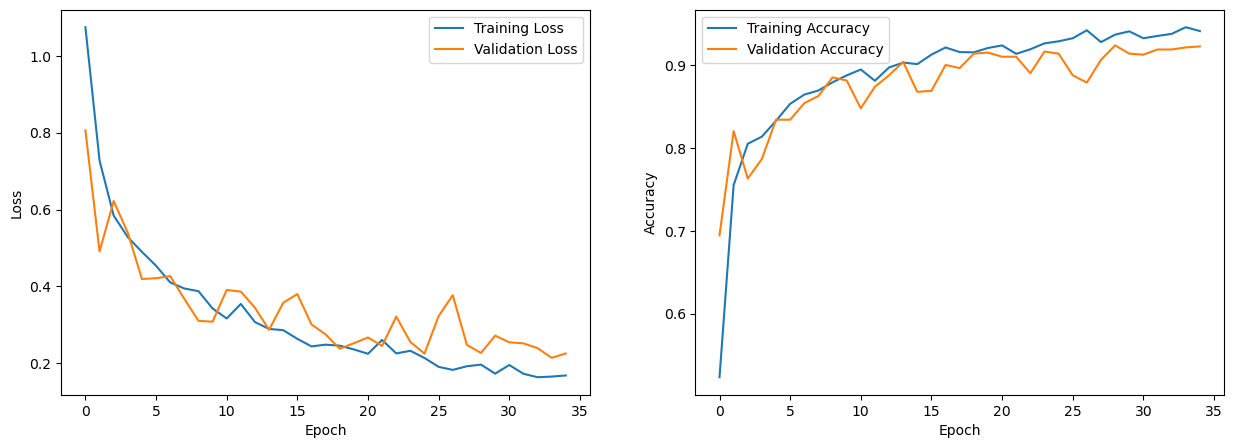

In [18]:
# Plot the training and validation loss and accuracy curves
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the smoothed training loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the smoothed training accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [22]:
model2.save('model2.keras')

In [23]:
# Load the trained model
model2 = keras.models.load_model('model2.keras')

In [2]:
import cv2
import numpy as np
from skimage import filters
from skimage.feature import graycomatrix, graycoprops
import mahotas
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
from skimage.restoration import estimate_sigma,denoise_nl_means
from keras.models import load_model
model2 = load_model('model2.keras')


# Load image
img = cv2.imread('img4.jpg')
filepath = os.path.join('img4.jpg')

# Resize image to 100x100
image = cv2.resize(img, (100, 100))
            
# Define the coordinates of the region of interest (ROI) for the pattern template
x, y, width, height = 50, 50, 50, 50  # Example coordinates and dimensions

# Extract the ROI (pattern template) from the larger image
pattern_template = image[y:y+height, x:x+width]
            
# Apply median filter
image = cv2.medianBlur(image, 3)

# Apply Gaussian filter
image = cv2.GaussianBlur(image, (5, 5), 0)

def extract_dominant_color(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    mean_lab = cv2.mean(lab)
    return mean_lab[0], mean_lab[1], mean_lab[2]

def extract_shape_feature(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to create a binary image
    _, binary_image = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # For simplicity, we'll use the number of contours as a shape feature
    shape_feature_value = len(contours)
    
    return shape_feature_value

def extract_size_feature(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to create a binary image
    _, binary_image = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total area of all objects in the image
    total_area = sum([cv2.contourArea(contour) for contour in contours])
    
    # Return the total area as the size feature
    return total_area
def extract_texture_feature(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate GLCM
    glcm = mahotas.features.haralick(gray)

    # You can choose a specific Haralick feature to represent the texture, e.g., correlation
    texture_feature_value = glcm.mean(axis=0)[8]  # 8 corresponds to correlation

    return texture_feature_value

def extract_pattern_feature(image, pattern_template):
    # Convert both the image and the pattern template to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pattern_gray = cv2.cvtColor(pattern_template, cv2.COLOR_BGR2GRAY)
    
    # Perform template matching
    result = cv2.matchTemplate(image_gray, pattern_gray, cv2.TM_CCOEFF_NORMED)
    
    # Set a threshold to identify matches
    threshold = 0.7  # Adjust as needed
    locations = np.where(result >= threshold)
    
    # Count the number of matching patterns
    num_matches = len(locations[0])
    
    return num_matches


            
dominant_color_L, dominant_color_A, dominant_color_B = extract_dominant_color(image)
shape_feature = extract_shape_feature(image)
size_feature = extract_size_feature(image)
texture_feature = extract_texture_feature(image)
pattern = extract_pattern_feature(image, pattern_template)
            
label=-1
            
# Feature vector
vector = [
                filepath,
                label,
                dominant_color_L,
                dominant_color_A,
                dominant_color_B,
                shape_feature,
                size_feature,
                texture_feature,
                pattern
            ]


# Convert the feature vector to a numpy array
feature_vector = np.array(vector)

# Reshape the feature vector to the shape expected by the model
test_feature_vector = feature_vector.reshape(1, -1)

# Convert the image to RGB
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape and normalize the image data
test_data = np.expand_dims(rgb_image, axis=0)
test_data = test_data / 255.0

# Predict the class of the test image
pred = model2.predict(test_data)

arr = ['daisy', 'dandelion','orchid','Unknown']

predicted_class = np.argmax(pred[0])
accuracy = pred[0][predicted_class]

print(f'The predicted class is: {arr[predicted_class]}')

1/1 [==============================] - 0s 278ms/step
The predicted class is: Unknown
